In [21]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import glob
import warnings
import sys
warnings.filterwarnings('ignore')
import argparse
from argparse import RawTextHelpFormatter
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/')
import utils as ut
import xarray as xr
import re

In [2]:
### extract salt and things
modname = 'TOM12_TJ_1AS1'
def check_progress(modname):
    baseDir = '/gpfs/afm/greenocean/software/runs/'
    path_to_files = f'{baseDir}/{modname}';
    ftype = 'grid_T'
    var = 'vosaline';
    yrstart = 1940
    yrend = 2100
    yrs = np.arange(1940,2101,1)
    indarray, list_of_nanyears = ut.check_for_nans(yrstart,yrend,path_to_files,ftype,var)
    print(list_of_nanyears)

    fact = 0.4
    fig, axs = plt.subplots(1,1, figsize=(20*fact, 6*fact), facecolor='w', edgecolor='k')

    axs.plot(yrs, indarray, 'ro')
    axs.set_title(f'model {modname} Diagnostic - Does model salinity look ok? \n 0=numbers where expected, 1 = nans in model, 2 = file not present')
    axs.grid()
    axs.legend()
    axs.set_xlim([yrstart,yrend])


[2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]


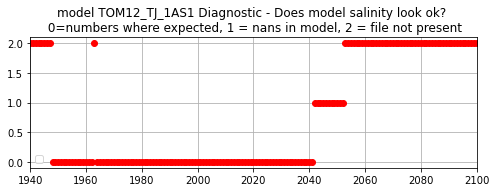

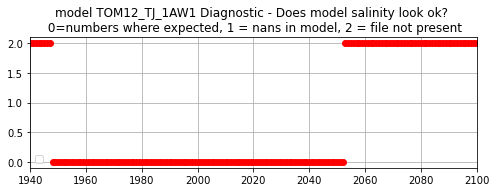

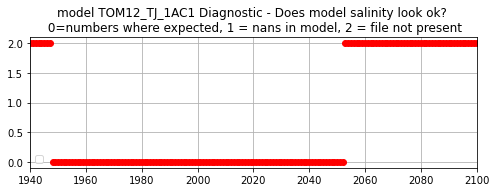

In [3]:
check_progress('TOM12_TJ_1AS1')
check_progress('TOM12_TJ_1AW1')
check_progress('TOM12_TJ_1AC1')

In [53]:
def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def max_min_yrs(tr, baseDir):
    w = glob.glob(f'{baseDir}{tr}/ORCA2_1m_*ptrc*.nc')
    yrs = []
    for i in range(0,len(w)):
        ts = (w[i])
        pattern = f'{baseDir}{tr}/ORCA2_1m_'
        mod_string = re.sub(pattern, '', ts)
        yrs.append(int(mod_string[0:4]))
        
    tmin = min(yrs); tmax = max(yrs)
    return tmin, tmax


In [68]:
baseDir = '/gpfs/home/mep22dku/scratch/ModelRuns/'

tr = 'TOM12_TJ_1AS5'
tmin, tmax = max_min_yrs(tr, baseDir)
tw_1AS5 = make_yearlist(tmin,tmax,'diad',tr, baseDir)
ds_1AS5 = xr.open_mfdataset(tw_1AS5)

tr = 'TOM12_TJ_1BS1'
tmin, tmax = max_min_yrs(tr, baseDir)
tw_1BS1 = make_yearlist(tmin,tmax,'diad',tr, baseDir)
ds_1BS1 = xr.open_mfdataset(tw_1BS1)

In [71]:
Cflx_mol_s_1AS5 = ds_1AS5['Cflx']*tmesh['csize']
cflx_1AS5 = np.nansum(np.nansum(Cflx_mol_s_1AS5.values,axis = 2),axis =1)
Cflx_mol_s_1BS1 = ds_1BS1['Cflx']*tmesh['csize']
cflx_1BS1 = np.nansum(np.nansum(Cflx_mol_s_1BS1.values,axis = 2),axis =1)

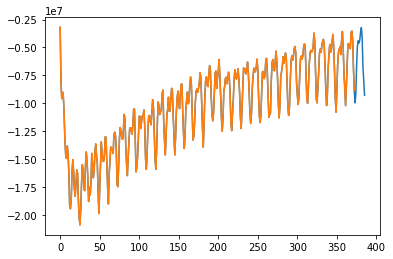

In [72]:
plt.plot(cflx_1AS5)
plt.plot(cflx_1BS1)

In [75]:
Cflx_mol_s_1AS5

<xarray.DataArray (time_counter: 386, y: 149, x: 182)>
dask.array<mul, shape=(386, 149, 182), dtype=float64, chunksize=(12, 149, 182), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    time_centered  (time_counter) object dask.array<chunksize=(12,), meta=np.ndarray>
  * time_counter   (time_counter) object 1948-01-16 12:00:00 ... 1980-02-15 0...
Dimensions without coordinates: y, x

In [79]:
Cflx_mol_s_1AS5

da_groupby_monthly = Cflx_mol_s_1AS5.groupby('time_centered.year').sum('time_counter')
print(da_groupby_monthly)

<xarray.DataArray (year: 33, y: 149, x: 182)>
dask.array<stack, shape=(33, 149, 182), dtype=float64, chunksize=(1, 149, 182), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
  * year     (year) int64 1948 1949 1950 1951 1952 ... 1976 1977 1978 1979 1980
Dimensions without coordinates: y, x


In [92]:
month_length = Cflx_mol_s_1AS5.time_centered.dt.days_in_month
# print(month_length.values)

wgts = month_length.groupby("time_centered.year") / month_length.groupby("time_centered.year").sum()
wgts

# print(wgts.groupby("time_centered.year").sum(xr.ALL_DIMS).values)

<xarray.DataArray 'days_in_month' (time_counter: 386)>
dask.array<concatenate, shape=(386,), dtype=float64, chunksize=(12,), chunktype=numpy.ndarray>
Coordinates:
    time_centered  (time_counter) object dask.array<chunksize=(12,), meta=np.ndarray>
  * time_counter   (time_counter) object 1948-01-16 12:00:00 ... 1980-02-15 0...
    year           (time_counter) int64 1948 1948 1948 1948 ... 1979 1980 1980

In [98]:
Cflx_mol_s_1AS5

def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time_counter.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time_centered.year") / month_length.groupby("time_centered.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time_centered.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time_counter="AS").sum(dim="time_counter")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time_counter="AS").sum(dim="time_counter")

    # Return the weighted average
    return obs_sum / ones_out




In [99]:
w = weighted_temporal_mean(Cflx_mol_s_1AS5)

In [102]:
print(w*365)

<xarray.DataArray (time_counter: 33, y: 149, x: 182)>
dask.array<mul, shape=(33, 149, 182), dtype=float64, chunksize=(1, 149, 182), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) object 1948-01-01 00:00:00 ... 1980-01-01 00...
    nav_lat       (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(149, 182), meta=np.ndarray>
Dimensions without coordinates: y, x


In [105]:
siy = 60*60*24*365
pg_in_mol = 12 * 1e-15

print(np.nansum(np.nansum(w*siy*pg_in_mol, axis = 2), axis = 1))

[-4.35090341 -6.58146916 -6.51669009 -6.06793038 -5.83666026 -5.58239218
 -5.14299401 -4.92905194 -4.74818325 -4.63615101 -4.372362   -4.14632614
 -3.99139644 -3.89719111 -3.66510669 -3.4702565  -3.25784955 -3.40929896
 -3.34645123 -3.15115312 -3.15757255 -3.17777348 -2.93329461 -2.8592492
 -2.7545745  -2.57376557 -2.40924337 -2.40593739 -2.39811185 -2.42769733
 -2.25408102 -2.21756654 -3.24780101]
